<a href="https://colab.research.google.com/github/scardenol/proc_est2/blob/main/P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [331]:
# Se corre una vez al abrir una nueva sesión
# !pip install arch

In [332]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt # gráficas
import matplotlib as mpl
from matplotlib import rc
import matplotlib.pylab as plt
from arch.unitroot import ADF # Augmented Dickey Fuller, test de estacionariedad
from scipy.optimize import curve_fit # LS fit
from IPython.display import display, Math

import seaborn as sns # gráficas
plt.style.use('seaborn-darkgrid') # estilo de gráficas
# plt.style.available 

import warnings
warnings.filterwarnings("ignore")

# 3. EDEL en Sentido Estricto con Nivel de Tendencia Funcional

## **Datos**

Se descargaron los datos del [Australian Government Bureau of Meteorology](http://www.bom.gov.au/climate/data/index.shtml), en particular, el histórico de [datos](http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_nccObsCode=122&p_display_type=dailyDataFile&p_stn_num=094029&p_startYear=) de temperatura máxima diaria para la región de Hobart:


*   **Estación:** Hobart (Ellerslie Road)
*   **Número:** 94029
*   **Apertura:** 1882
*   **Estado actual:** Abierta
*   **Latitud, longitud:** 42.88°S, 147.33°E
*   **Elevación:** 51 m




In [333]:
# Urls raw del repo de github
url = 'https://github.com/scardenol/proc_est2/blob/main/data/IDCJAC0010_094029_1800_Data.csv?raw=true'

# Leer los datos en csv
data = pd.read_csv(url, delimiter=',')
data.index = pd.to_datetime((data['Year']*10000+data['Month']*100+data['Day']).apply(str), format='%Y-%m-%d')

# Filtrar de 2017 a 2021
data = data.loc['2017-01-01':'2021-01-01']

# Filtrar columna de temperatura máxima
data = data['Maximum temperature (Degree C)']

# Quitar valores NA
data = data.dropna()

# Separación de datos en train y test
mid = len(data)//2
train = data[:mid+1]
test = data[mid+1:]

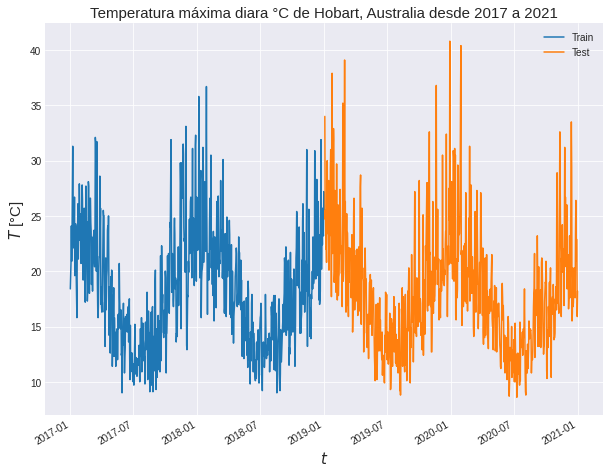

In [334]:
# Visualizar

plt.figure(figsize=(10,8))
train.plot();
test.plot();
title = r'Temperatura máxima diara °C de Hobart, Australia desde 2017 a 2021'
plt.title(title, fontsize = 15);
plt.xlabel('$t$', fontsize = 15);
plt.ylabel('$T$ [°C]', fontsize = 15);
plt.legend(['Train','Test']);

En la serie de datos se nota la presencia de una tendencia funcional periódica, sujeta de ser modelada por una función trigonométrica (seno, coseno). Esto quiere decir que se observan comportamientos de estacionariedad y periodicidad en la serie.

## Condiciones de modelación

La serie debe cumplir con ser estacionaria (tendencia funcional) y ser periódica. Por lo tanto se realiza lo siguiente:

*   **Augmented Dickey-Fuller (ADF):** test de estacionariedad. Asumiendo $\alpha = 0.05$, se tienen las hipótesis

\begin{align*}
  &\mathcal{H_0}: \quad \text{La serie no es estacionaria} \; (p>\alpha). \\
  &\mathcal{H_A}: \quad \text{La serie es estacionaria} \; (p\leq\alpha).
\end{align*}

*   **Fast Fourier Transform (FFT):** transformada rápida de Fourier. Se utiliza para validar la presencia de componentes frecuenciales en los datos, y por lo tanto, periodicidad.


In [335]:
# Test ADF (Augmented Dickey-Fuller) para estacionalidad
# https://arch.readthedocs.io/en/latest/unitroot/unitroot_examples.html
adf = ADF(train)
print(adf.summary().as_text()) # Se rechaza H0, la serie es estacionaria

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.860
P-value                         0.050
Lags                                9
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [336]:
# FFT (Fast Fourier Transform) para periodicidad de los datos

N = len(train) # number of data points
t = np.linspace(0, 4*np.pi, N)

data = train - train.mean() # Se resta la media, pues el término 1 de fft es la media
mfft=np.fft.fft(data)
imax=np.argmax(np.absolute(mfft))
mask=np.zeros_like(mfft)
mask[[imax]]=1
mfft*=mask

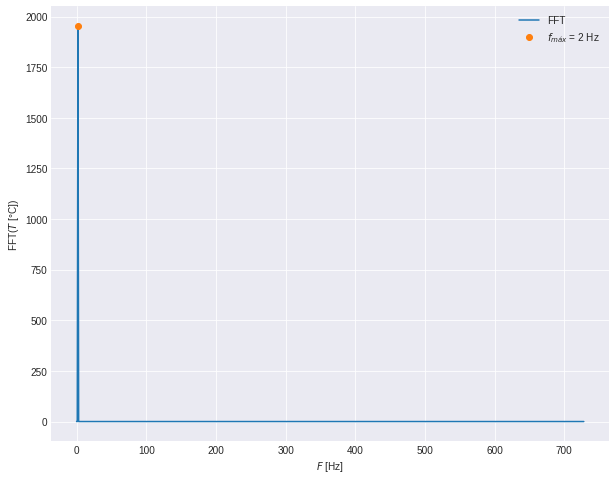

In [337]:
# Visualizar FFT

plt.figure(figsize=(10,8))

plt.plot(mfft)
fmax, fmax_idx = (np.max(mfft), np.argmax(mfft))
plt.plot(fmax_idx, fmax, 'o');
plt.xlabel('$F$ [Hz]');
plt.ylabel('FFT($T$ [°C])');
plt.legend(['FFT', '$f_{máx}$ = ' + str(fmax_idx) + ' Hz']);

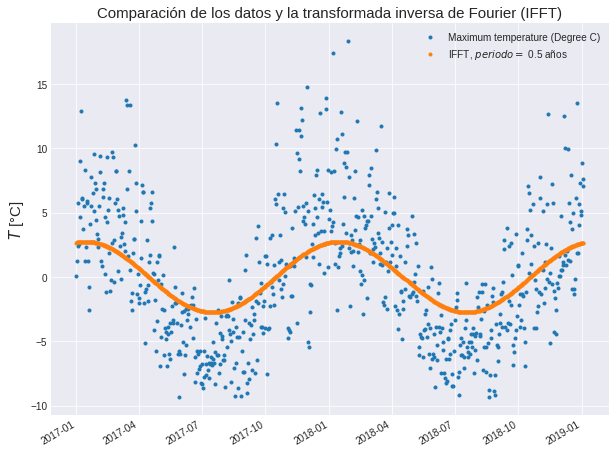

In [338]:
# Visualizar transformada inversa del resultado anterior

fdata=np.fft.ifft(mfft) # Transformada inversa de Fourier
data = pd.Series(data, train.index)
fdata = pd.Series(fdata, train.index)
Tdata = 1/fmax_idx # Periodo = 0.5 años = 6 meses

plt.figure(figsize=(10,8))

data.plot(style='.')
fdata.plot(style='.', label='IFFT, $periodo =$ ' + str(round(Tdata, 2)) + ' años')
title = 'Comparación de los datos y la transformada inversa de Fourier (IFFT)'
plt.title(title, fontsize = 15);
plt.ylabel('$T$ [°C]', fontsize = 15);
plt.legend()
plt.show()

## Estimación de parámetros

De acuerdo con [Alaton, Djehiche & Stillberger (2002)](https://www.tandfonline.com/doi/abs/10.1080/13504860210132897), la EDEL en Sentido Estricto con Nivel de Tendencia Funcional que sigue el proceso, es de la forma

\begin{gather*}
  dT_t = \bigg[\frac{dT_t^m}{dt} + a(T_t^m - T_t)\bigg]dt + \sigma_tdW_t, \quad T_0 = x \\
  \frac{dT_t^m}{dt} = B + \omega C\cos(\omega t + \varphi)
\end{gather*}

Donde
* $T_t^m$ es la temperatura promedio,
* $t > 0$,
* $\{W_t\}_{t\geq0}$ es un MBEU, 
* $a \in \mathbb{R}$ determina la velocidad de reversión a la media, 
* $\sigma_t > 0$ es la volatilidad (usualmente mensual),
* $\omega = \frac{2\pi}{T} = \frac{2\pi}{365}$ es la frecuencia angular, considerando 1 año de oscilaciones ($T = 365$ días).

Note que el proceso es un proceso de Ornstein-Uhlenbeck al que se le agrega el término $\frac{dT_t^m}{dt}$ al término drift.

La solución del proceso es de la forma 

\begin{gather*}
  T_t = (T_0 - T^m_0)\exp[-at] + T^m_t + \int_0^t exp[-a(t-s)] \sigma_s dW_s\\
  \text{donde}\quad T^m_t = A + Bt + C\sin(\omega t + \varphi).
\end{gather*}

### a) Estimación de los parámetros $A$, $B$, $C$ y $\varphi$.

Para estimar los parámetros de la ecuación $T^m_t = A + Bt + C\sin(\omega t + \varphi)$, se ajusta la siguiente función $Y_t$ a los datos, donde

\begin{equation}
  Y_t = a_1 + a_2t + a_3\sin(\omega t) + a_4\cos(\omega t)
\end{equation}

donde la idea es implementar mínimos cuadrados para encontrar el vector de parámetros $\theta = (a_1, a_2, a_3, a_4)$ que resuelva $\underset{\theta}{\min} || Y - X ||^2$, donde $Y$ es el vector resultante de $Y_t$ y $X$ son los datos. Entonces los parámetros se estiman como

\begin{equation}
  \hat{A} = a_1, \quad \hat{B} = a_2, \quad \hat{C} = \sqrt{a_3^2 + a_4^2}, \quad \hat{\varphi} = \arctan\bigg(\frac{a_4}{a_3}\bigg) - \pi
\end{equation}

In [339]:
omg = 2*np.pi/365

def Yt(t, a1, a2, a3, a4):
  model = a1 + a2*t + a3*np.sin(omg*t) + a4*np.cos(omg*t)
  return model

T = np.linspace(0, len(train), num = len(train)) # Intervalo equiespaciado de tiempo

a1, a2, a3, a4 = curve_fit(Yt, T, train.values)[0] # Mínimos cuadrados

A_hat = a1
B_hat = a2
C_hat = np.sqrt(a3**2 + a4**2)
phi_hat = abs(np.arctan(a4/a3) - np.pi)

display(Math(r'\hat{A} = ' + str(round(A_hat, 2))))
display(Math(r'\hat{B} = ' + '{:0.2e}'.format(B_hat)))
display(Math(r'\hat{C} = ' + str(round(C_hat, 2))))
display(Math(r'\hat{\varphi} = ' + str(round(phi_hat, 2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

\begin{equation}
  \therefore T^m_t = \hat{A} + \hat{B}t + \hat{C}\sin(\omega t + \hat{\varphi})
  \nonumber
\end{equation}

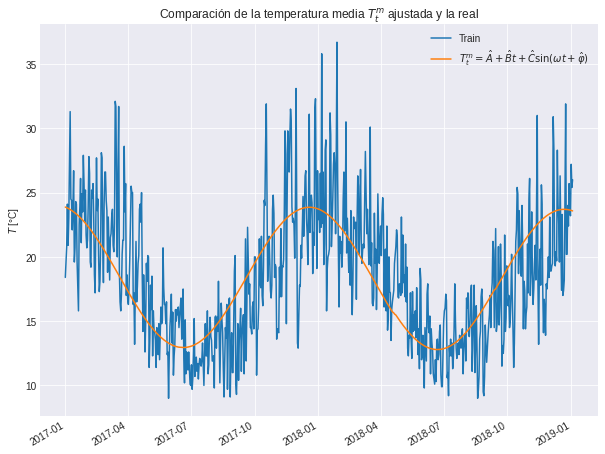

In [340]:
# Visualizar la temperatura promedio ajustada

Tm = A_hat + B_hat*T + C_hat*np.sin(omg*T + abs(phi_hat))
Tm = pd.Series(Tm, index=train.index)

plt.figure(figsize=(10,8))

title = 'Comparación de la temperatura media $T^m_t$ ajustada y la real'
train.plot(title=title);
Tm.plot()
plt.legend(['Train', r'$T^m_t = \hat{A} + \hat{B}t + \hat{C}\sin(\omega t + \hat{\varphi})$']);
plt.ylabel('$T$ [°C]');

### b) Estimación de los parámetros $\sigma$ y $a$.

Dado un mes específico $\mu$ de $N_\mu$ días, $T_j$ denota las temperaturas observadas (datos reales) durante el mes $\mu$, con $j = 1, 2, ..., N_\mu$. Utilizando el estimadaor de $\sigma$ basado en la variación cuadrática de $T_t$, se obtiene entonces que

\begin{equation}
  \hat{\sigma}^2_\mu = \frac{1}{N_\mu} \sum_{j=0}^{N_\mu - 1} (T_{j+1} - T_j)^2
\end{equation}

In [341]:
# Suma mensual
def msum(x):
  N = len(x.index.day)
  D = x.diff()**2
  S = D.sum()
  return (1/N)*S

sigma2_hat = [train[str(_)].groupby(train[str(_)].index.month).agg(msum) for _ in train.index.year.unique()]
sigma2_hat = pd.concat([sigma2_hat[_] for _ in range(len(sigma2_hat))])
sigma2_hat = sigma2_hat.rename('sigma2_hat')
sigma_hat = np.sqrt(sigma2_hat)
sigma_hat = sigma_hat.rename('sigma_hat')
pd.DataFrame({'sigma2_hat':round(sigma2_hat, 2)})

,sigma2_hat
1,11.66
2,14.04
3,21.12
4,10.89
5,9.36
6,5.82
7,3.73
8,9.84
9,15.18
10,13.26


Por otra parte, para estimar el parámetro $a$ se usa el estimador

\begin{gather*}
  \hat{a}_n = -\log\Bigg[\frac{\sum_{i=1}^n Y_{i-1}\big(T_i-T^m_i\big)}{\sum_{i=1}^n Y_{i-1}\big(T_{i-1}-T^m_{i-1}\big)}\Bigg]\\
  \text{donde} \quad Y_{i-1} := \frac{T^m_{i-1}-T_{i-1}}{\hat{\sigma}^2_{i-1}}, \quad i=1,2, ..., n
\end{gather*}

y $n$ es el número de observaciones (datos). Reescribiendo las ecuaciones con las sumas empezando en $n=0$ se obtiene

\begin{gather*}
  \hat{a}_n = -\log\Bigg[\frac{\sum_{i=0}^{n-1} Y_i\big(T_{i+1}-T^m_{i+1}\big)}{\sum_{i=0}^{n-1} Y_i\big(T_i-T^m_i\big)}\Bigg]\\
  \text{donde} \quad Y_i := \frac{T^m_i-T_i}{\hat{\sigma}^2_i}, \quad i=1,2, ..., n
\end{gather*}

In [342]:
# Días por mes de los datos observados
obs = [train[str(_)].groupby(train[str(_)].index.month).count() for _ in train.index.year.unique()]
obs = pd.concat([obs[_] for _ in range(len(obs))])
S2 = sigma2_hat.repeat(obs.values) # Repetir observaciones mensuales n días, sigma^2 diario
S2.index = train.index
S2 = S2.rename('sigma2_hat')

D = Tm-train
D1 = D.iloc[:-1] # De 0 hasta n-1
D2 = D.iloc[1:]  # De 1 hasta n 
Yi = D1/(S2.iloc[:-1])

num = (Yi*D2).sum()
den = (Yi*D1).sum()

a_hatn = -np.log(num/den)
display(Math(r'\hat{a}_n = ' + '{:0.2e}'.format(a_hatn)))

<IPython.core.display.Math object>

### c) Simulación del modelo resultante.

Después de obtener los parámetros, es posible realizar la simulación del proceso. El modelo del proceso 

\begin{gather*}
  dT_t = \bigg[\frac{dT_t^m}{dt} + a(T_t^m - T_t)\bigg]dt + \sigma_tdW_t, \quad T_0 = x \\
  \frac{dT_t^m}{dt} = B + \omega C\cos(\omega t + \varphi) \\
  T^m_t = A + Bt + C\sin(\omega t + \varphi)
\end{gather*}

Aproximando por Euler-Maruyama se obtiene

\begin{gather*}
  T(t) = T(t-1) + \bigg[\Delta T^m(t-1) + a(T^m(t-1) - T(t-1))\bigg]\Delta t + \sigma_t\Delta W_t, \quad T(0) = x \\
  \Delta T^m(t) = T^m(t-1) + B + \omega C\cos(\omega \Delta t + \varphi) \\
  T^m(t) = A + B\Delta t + C\sin(\omega \Delta t + \varphi)
\end{gather*}

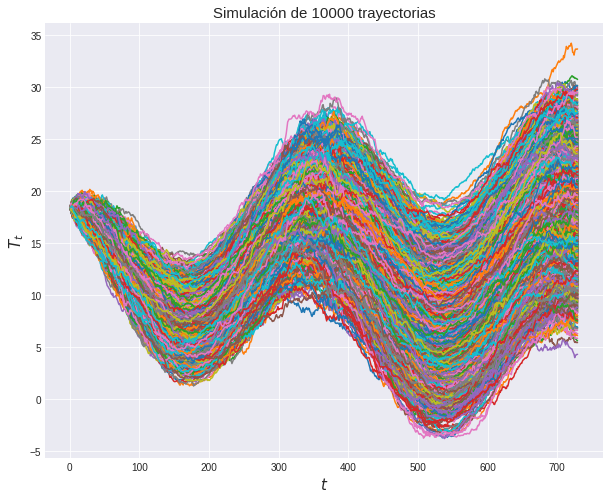

In [343]:
# Simulación

l = 10000 # número de simulaciones
p = len(train) # número de observaciones

# Delta Tm
T = np.linspace(0, p, num = p) # Intervalo equiespaciado de tiempo
dTm = B_hat + omg*C_hat*np.cos(omg*T + abs(phi_hat))

X = np.zeros((l,p))
dt = 1/p # Delta de t de la solución discreta
T = np.linspace(dt, 1, p) # Intervalo equiespaciado en [0,1]

A = A_hat
B = B_hat
C = C_hat
phi = phi_hat
omega = omg
sigma = np.sqrt(S2)
a = a_hatn

X0 = train[0] # Valor inicial

plt.figure(figsize=(10,8))
for sim in range(l): # Ciclo de simulaciones
  X[sim,0] = X0
  for t in range(1, p): # Ciclo de observaciones
    dWt = np.sqrt(dt)*np.random.normal(0,1) # Delta de Bt de la sol. discreta
    # Solución numérica
    X[sim, t] =  (X[sim, t-1] - Tm[t-1])*np.exp(-a*dt) + Tm[t] + sigma[t]*dWt
  plt.plot(p*T, X[sim]);

title = 'Simulación de ' + str(l) + r' trayectorias'
plt.title(title, fontsize = 15);
plt.xlabel('$t$', fontsize = 15);
plt.ylabel('$T_t$', fontsize = 15);

## Pronóstico

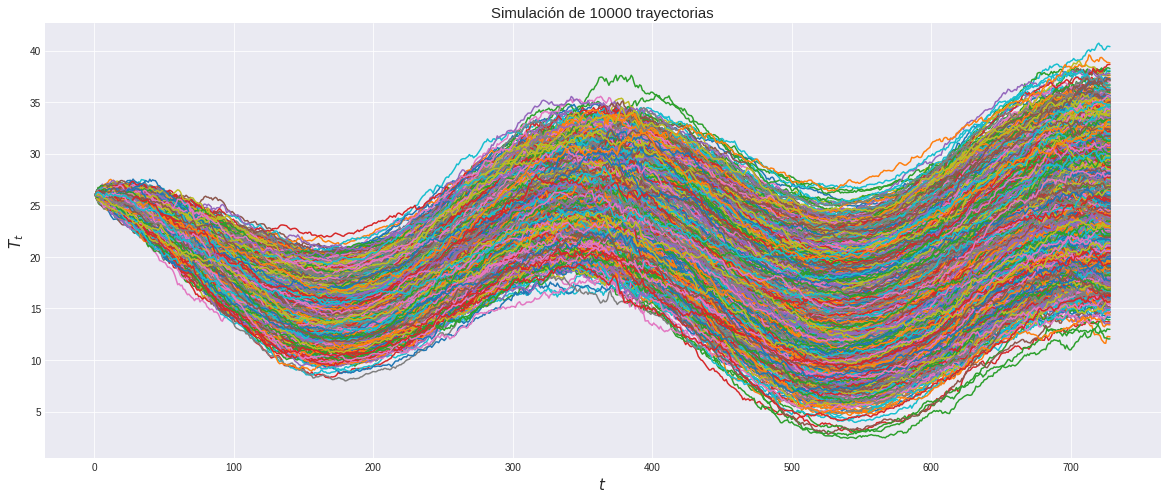

In [344]:
# Pronóstico de los datos de test

l = 10000 # número de simulaciones
p = len(test) # número de observaciones

# Delta Tm
T = np.linspace(0, p, num = p) # Intervalo equiespaciado de tiempo
dTm = B_hat + omg*C_hat*np.cos(omg*T + abs(phi_hat))

# Tm
Tm = A_hat + B_hat*T + C_hat*np.sin(omg*T + abs(phi_hat))
Tm = pd.Series(Tm, index=test.index)

X_hat = np.zeros((l,p))
dt = 1/p # Delta de t de la solución discreta
T = np.linspace(dt, 1, p) # Intervalo equiespaciado en [0,1]

A = A_hat
B = B_hat
C = C_hat
phi = phi_hat
omega = omg
sigma = np.sqrt(S2)
a = a_hatn

X0 = train[-1] # Valor inicial

plt.figure(figsize=(20,8))
for sim in range(l): # Ciclo de simulaciones
  X_hat[sim,0] = X0
  for t in range(1, p): # Ciclo de observaciones
    dWt = np.sqrt(dt)*np.random.normal(0,1) # Delta de Bt de la sol. discreta
    # Solución numérica
    X_hat[sim, t] =  (X_hat[sim, t-1] - Tm[t-1])*np.exp(-a*dt) + Tm[t] + sigma[t]*dWt
  plt.plot(p*T, X_hat[sim]);

title = 'Simulación de ' + str(l) + r' trayectorias'
plt.title(title, fontsize = 15);
plt.xlabel('$t$', fontsize = 15);
plt.ylabel('$T_t$', fontsize = 15);

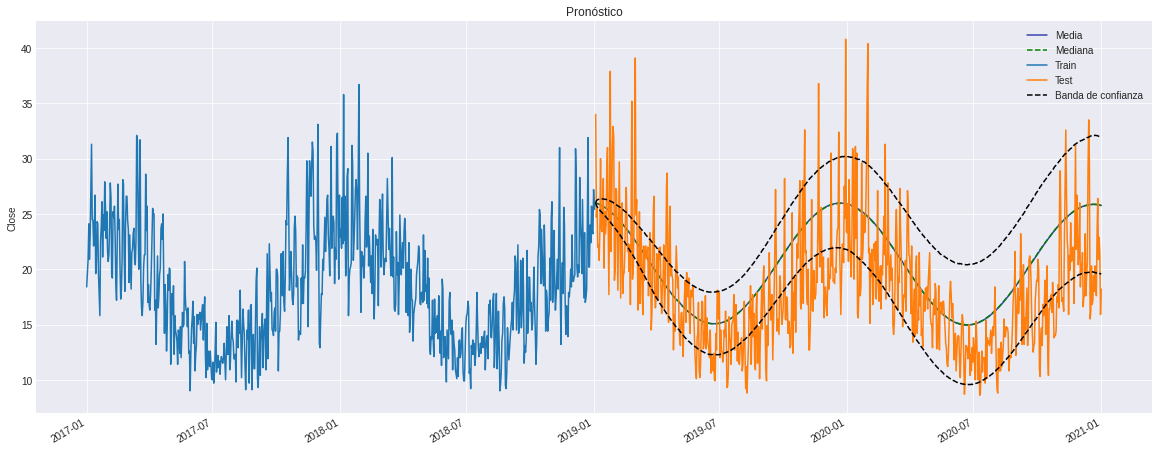

In [345]:
# Visualizar

fig1 = plt.figure(figsize=(20,8))

X_hat = pd.DataFrame(X_hat) 
X_hat_mean = pd.Series(X_hat.mean(axis=0).values, index=test.index)
X_hat_mean.plot(color='#3743ad');
X_hat_median = pd.Series(X_hat.quantile(q=0.5, axis=0).values, index=test.index)
X_hat_median.plot(style='--', color='green');

train.plot()
test.plot(title='Pronóstico');

# Bandas de confianza
X_hat_hi = pd.Series(X_hat.quantile(q=0.95, axis=0).values, index=test.index)
X_hat_hi.plot(style='--', color='black');
X_hat_lo = pd.Series(X_hat.quantile(q=0.05, axis=0).values, index=test.index)
X_hat_lo.plot(style='--', color='black');

plt.ylabel('Close');
plt.legend(['Media', 'Mediana', 'Train','Test', 'Banda de confianza']);